In [1]:
from ilqr.envs import PointMass, PointMassDm, Arm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [42]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6,        # dreg is multiplied or diveded by dreg_factor):
         alpha = 1,
         verbose = False,
        ):        

    # initial trajectory
    actions = [np.array((0,0)) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    history = dict(cost=[sum(costs)], reg=[reg])
    
    if verbose:
        headers = '{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}'.format(
            'iteration', 'cost', 'dcost', 'expected', 'reg', 'status', 'max_action')
        print(headers, '\n' + ''.join(['-']*len(headers)))

    for i in tqdm(range(iterations)) if not verbose else range(iterations):
        
        # differentiate trajectory
        states, costs, costs_derivs = env.rollout(actions)
        state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
        
        # backward pass
        # (compute new control rules k and K)
        complete = False
        while not complete:
            k, K = [], []
            dV = 0
            V_x  = costs_derivs[-1]['l_x']
            V_xx = costs_derivs[-1]['l_xx']
            
            for t in range(env.max_steps-1, -1, -1):
                l, f = costs_derivs[t], state_derivs[t]    

                Q_x  = l['l_x']  + f['f_x'].T @ V_x
                Q_u  = l['l_u']  + f['f_u'].T @ V_x
                Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
                Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
                Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

                # compute controls k and K
                Q_uu = .5 * (Q_uu + Q_uu.T)  # make sure perfectely symmetric by averaging off-diagonals
                Q_uu_reg = Q_uu + np.diag(np.repeat(reg, len(Q_u)))
                
                try:
                    # cholesky decomposition instead of matrix inverse
                    L = np.linalg.cholesky(Q_uu_reg)
                    k.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_u)))
                    K.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_ux)))
                except np.linalg.LinAlgError:
                    # increase regularization
                    dreg = max(dreg_factor, dreg_factor*dreg)
                    reg = max(reg*dreg, reg_lims[0])
                    complete = False
                    break
                    
                # update V
                dV  +=   alpha**2*.5 * k[-1].T @ Q_uu @ k[-1] + alpha*k[-1].T @ Q_u  # expected cost reduction
                V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
                V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]
                V_xx = .5 * (V_xx + V_xx.T)  # make sure perfectely symmetric by averaging off-diagonals
                complete = True
        
        k.reverse()
        K.reverse()
        
        # forward pass
        # (compute new trajectory with new control law)
        costs_new, actions_new = [], []
        env.reset(reset_target=False)
        
        for t in range(env.max_steps):
            actions_new.append(actions[t] + alpha*k[t] + K[t] @ (env.state - states[t]))
            costs_new.append(env.cost(env.state, actions_new[-1]))
            env.step(actions_new[-1])
        costs_new.append(env.cost_final(env.state))
        
        history['cost'].append(sum(costs_new))
        delta_cost = sum(costs_new) - sum(costs)
        
        # increase regularization
        if delta_cost>=0:
            dreg = max(dreg_factor, dreg_factor*dreg)
            reg = max(reg*dreg, reg_lims[0])
            flag = 'increased'

        # decrease regularization
        else:
            dreg = min(1/dreg_factor, dreg/dreg_factor)
            reg *= dreg * (reg > reg_lims[0])  # latter term sets reg=0 if reg<=reg_lims[0]
            flag = 'decreased'
            
            # update actions
            actions = actions_new.copy()
            
        history['reg'].append(reg)
        
        if verbose:
            print('{:6d}/{:<5d}{:<12.6f}{:<+12.2e}{:<+12.2e}{:<12.2e}{:<12s}{:<12.6f}'.format(
                i, iterations, history['cost'][-1], delta_cost, dV, reg, flag, np.abs(np.array(actions)).max()))
    
    return actions, history

# point mass

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     0/10   5.365643    -2.16e+01   -2.16e+01   6.25e-01    decreased   0.436170    
     1/10   4.005046    -1.36e+00   -1.36e+00   2.44e-01    decreased   0.802550    
     2/10   3.095633    -9.09e-01   -9.09e-01   5.96e-02    decreased   1.346372    
     3/10   2.265955    -8.30e-01   -8.30e-01   9.09e-03    decreased   2.511195    
     4/10   1.509308    -7.57e-01   -7.57e-01   8.67e-04    decreased   5.672241    
     5/10   1.007397    -5.02e-01   -5.02e-01   5.17e-05    decreased   14.701010   
     6/10   0.902751    -1.05e-01   -1.05e-01   1.93e-06    decreased   29.036757   
     7/10   0.893539    -9.21e-03   -9.21e-03   4.48e-08    decreased   48.599621   
     8/10   0.893176    -3.63e-04   -3.63e-04   0.00e+00    decreased   52.447761   
     9/10   0.893176    -3.74e-08   -3.74e-08   0.00e+00    decr

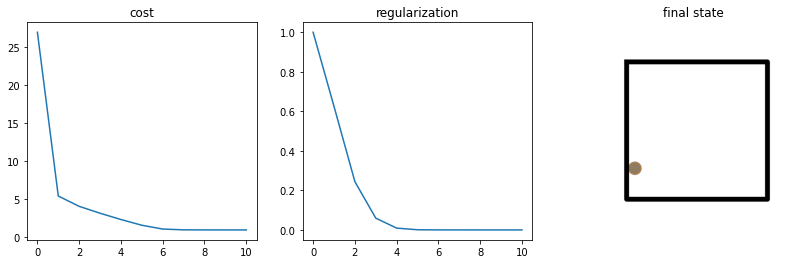

In [43]:
# run ilqr
env = PointMass(max_time=5)
actions, history = iLQR(env, iterations=10, reg=1, verbose=True)
ax = plt.subplots(1, 3, figsize=(14,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].set_title('final state'); env.show(); 

In [44]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))

# point mass (`dm_control`)

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     0/10   0.399878    -5.12e-02   -5.13e-02   6.25e-01    decreased   0.034671    
     1/10   0.336605    -6.33e-02   -6.35e-02   2.44e-01    decreased   0.082829    
     2/10   0.244714    -9.19e-02   -9.33e-02   5.96e-02    decreased   0.170920    
     3/10   0.148729    -9.60e-02   -9.98e-02   9.09e-03    decreased   0.345653    
     4/10   0.101311    -4.74e-02   -5.47e-02   8.67e-04    decreased   0.751444    
     5/10   0.085754    -1.56e-02   -2.66e-02   5.17e-05    decreased   1.664435    
     6/10   0.083867    -1.89e-03   -4.57e-03   1.93e-06    decreased   2.254444    
     7/10   0.083881    +1.36e-05   -3.16e-04   3.08e-06    increased   2.254444    
     8/10   0.083850    -1.79e-05   -2.56e-04   1.93e-06    decreased   3.288593    
     9/10   0.083807    -4.23e-05   -1.05e-04   7.52e-07    decr

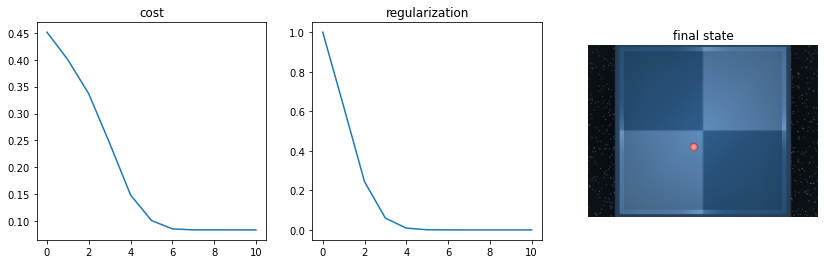

In [56]:
# run ilqr
env = PointMassDm(max_steps=100, control_wgt=0)
actions, history = iLQR(env, iterations=10, reg=1, verbose=True)
ax = plt.subplots(1, 3, figsize=(14,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].set_title('final state'); env.show(); 

In [57]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))

# two link arm

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     0/5    0.346801    -1.32e-02   -1.32e-02   6.25e-01    decreased   0.017324    
     1/5    0.234831    -1.12e-01   -2.14e-01   2.44e-01    decreased   0.585242    
     2/5    0.101328    -1.34e-01   -2.52e-01   5.96e-02    decreased   0.691244    
     3/5    0.085804    -1.55e-02   -1.68e-02   9.09e-03    decreased   0.755068    
     4/5    0.069666    -1.61e-02   -2.38e-02   8.67e-04    decreased   1.036973    


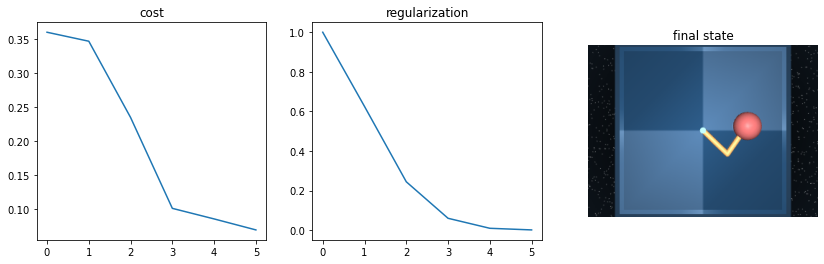

In [4]:
# run ilqr
env = Arm(max_steps=50)
actions, history = iLQR(env, iterations=5, reg=1, alpha=1, verbose=True, reg_lims=(1e-6, 1e10))
ax = plt.subplots(1, 3, figsize=(14,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].set_title('final state'); env.show(); 

In [5]:
# show video
env.reset(reset_target=False)
imgs = [env.render()]
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))
